In [ ]:
#importations nécessaires
from numpy.random import seed
seed(101) 
from tensorflow.random import set_seed
set_seed(101)
import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# le nombre d'image on veut dans chaque classe
NUM_AUG_IMAGES_WANTED = 1000 
# re dimensioner les images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [ ]:
#path du dataset qui se trouve dans notre cas en drive , qui contient trois autres fichiers
os.listdir('/content/drive/MyDrive/dataset_4G')

['Montgomery', 'ChinaSet_AllFiles', 'model.h5']

In [ ]:
#lire combient d'image dans chaque dataset
#china est une dataset de la chine 
print(len(os.listdir('/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))
#montgomery dataset from usa une ville 
print(len(os.listdir('/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png')))

663
139


In [ ]:
#stocker les path des deux dataset dans les deux variables
shen_image_list = os.listdir('/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png')

In [ ]:
#stockage  du dataframe en fait le parcour sur dataset 
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# supression des images qui contient le nom thumbs pour garder dataset clean 
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)
#affichage du shape
print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [ ]:
#affichage du dataframe(image name)
df_shen.head()

,image_id
0,CHNCXR_0004_0.png
1,CHNCXR_0008_0.png
2,CHNCXR_0007_0.png
3,CHNCXR_0002_0.png
4,CHNCXR_0003_0.png


In [ ]:
#affichage du head du dataframe du 2eme dataset
df_mont.head()

,image_id
0,MCUCXR_0002_0.png
1,MCUCXR_0001_0.png
2,MCUCXR_0008_0.png
3,MCUCXR_0003_0.png
4,MCUCXR_0004_0.png


In [ ]:
# selection du derniere index 
# example: CHNCXR_0470_1.png --> 1 mean TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [ ]:
# ajout d'un colonne pour la cible

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [ ]:
#verifier la distribution des target entre 1 et 0, puis l'affichage
# Shenzen Dataset
df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [ ]:
# Montgomery Dataset, affichage de la cible apres l'ajout

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [ ]:
#parcorir dataset pour afficher l'image par cible
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()

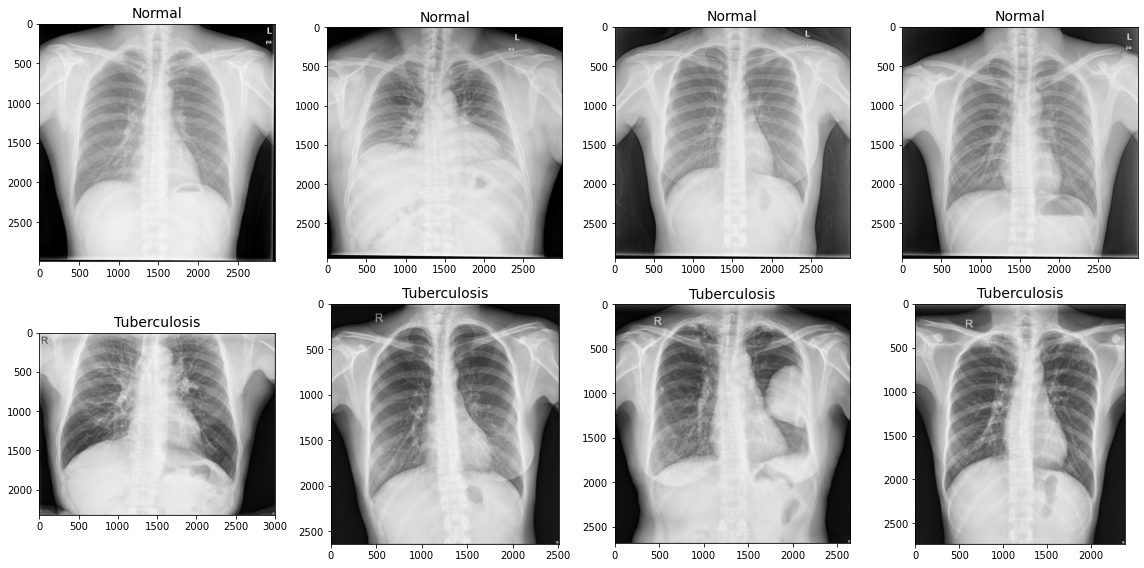

In [ ]:
# Shenzen Dataset du china

IMAGE_PATH = '/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

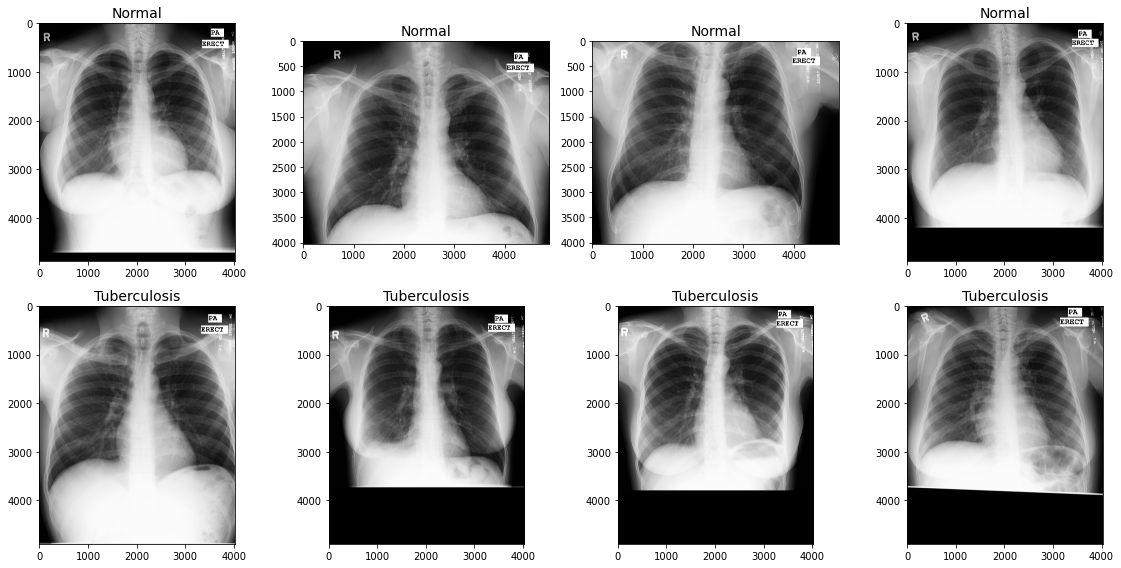

In [ ]:
# Montgomery Dataset

IMAGE_PATH = '/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

In [ ]:

def read_image_sizes(file_name):
    #shape
    image = cv2.imread(IMAGE_PATH + file_name)
    #max pixel 
    max_pixel_val = image.max()
    #min pixel
    min_pixel_val = image.min()
    
    # image.shape[2] represente nombre de channels : (height, width, num_channels)..
    if len(image.shape) > 2:    
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    # si l;image n'a pas de channels (height, width)
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'
#l'ajout des colonnes hauteur , largeur et channels ou filtres
m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)
#affichage
df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
1,CHNCXR_0008_0.png,Normal,2937,3000,3,255,0
2,CHNCXR_0007_0.png,Normal,2320,2306,3,255,0
3,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
4,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png/'
#merge entre les colonnes
m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)
#affichage apres merging
df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0008_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0


In [ ]:
#combient de channels dans chaque images dans dataset shen
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [ ]:
#combient de channels dans chaque images pour 2eme dataset montgomery
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [ ]:
#affichage de nombre de target by personnes's state
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [ ]:
#concatenation entre les deux datasets
df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)
#melange des deux dataset
df_data = shuffle(df_data)
#affichage du final shape
df_data.shape

(800, 7)

In [ ]:
#coder les variable qualitative (cible) en utilisant onehotencoder tuberculosis----->>1 , -normal---->>0 
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [ ]:
#affichahge 
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
679,MCUCXR_0026_0.png,Normal,4892,4020,3,255,0,0
177,CHNCXR_0179_0.png,Normal,2941,3000,3,255,0,0
60,CHNCXR_0058_0.png,Normal,2937,3000,3,255,0,0
782,MCUCXR_0338_1.png,Tuberculosis,4892,4020,3,253,0,1
667,MCUCXR_0011_0.png,Normal,4892,4020,3,255,0,0


In [ ]:
# train_test_split
y = df_data['labels']
#15% pour le test et 85 pour le training
df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)
#affichage du shape of chaque  test, and train
print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [ ]:
#affichage dataset dutrain 
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [ ]:
#affichage du dataset de la validation
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

In [ ]:
#creation de directory strucure dans Base directory pour separer les cas des test(normal,tuberculosis)et validation(normal,tuberculosis)
#nouvelle directory
base_dir = 'base_dir'
os.mkdir(base_dir)
#deux fichiers dans directory dase_dir
# train
    # Normal
    # Tuberculosis

# validation
    # Normal
    # Tuberculosis
# créer un chemin vers 'base_dir' auquel nous joindrons les noms des nouveaux dossiers
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# validation val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CRÉER DES DOSSIERS À L'INTÉRIEUR DES DOSSIERS DE TRAIN ET DE VALIDATION]
# Dans chaque dossier, nous créons des dossiers séparés pour chaque classe

# créer de nouveaux dossiers dans train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# créer de nouveaux dossiers dans val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

In [ ]:
#transferer les images dans le dossier
#Définissez l'image_id comme index dans df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
#Obtenir une liste d'images dans chacun des deux dossiers
folder_1 = os.listdir('/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png')
# obtenir la liste de train et de val des images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
# Transfer the train images
for image in train_list:
    fname = image
    label = df_data.loc[image,'target']   
    if fname in folder_1:
        # le chemin source vers l'image
        src = os.path.join('/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # chemin destination vers l'image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # sauvegarde des images en destination
        cv2.imwrite(dst, image)
      #test
    if fname in folder_2:
         # le chemin source vers l'image
        src = os.path.join('/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png', fname)
        # chemin destination vers l'image
        dst = os.path.join(train_dir, label, fname)   
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # sauvegarde des images en destination
        cv2.imwrite(dst, image)
# Transfer des images de validation
for image in val_list: 
    fname = image
    label = df_data.loc[image,'target'] 
    if fname in folder_1:
        src = os.path.join('/content/drive/MyDrive/dataset_4G/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        dst = os.path.join(val_dir, label, fname)
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
    if fname in folder_2:
        src = os.path.join('/content/drive/MyDrive/dataset_4G/Montgomery/MontgomerySet/CXR_png', fname)
        dst = os.path.join(val_dir, label, fname)
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

In [ ]:
#vérifier combien d'images de train nous avons dans chaque dossier
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [ ]:
# vérifier combien d'images de validation nous avons dans chaque dossier
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [ ]:
#Copiez les images du train dans aug_dir
class_list = ['Normal','Tuberculosis']

for item in class_list:
     #Nous créons ici des répertoires temporaires car nous supprimons ces répertoires plus tard.
     # créer un répertoire de base
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # créer un répertoire dans le répertoire de base pour stocker des images de la même classe
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)
    # choisir de la classe
    img_class = item
    #lister toutes les images de ce répertoire
    img_list = os.listdir('base_dir/train_dir/' + img_class)
    #Copiez les images du répertoire du train de classe vers img_dir, par ex. classe 'normale'
    for fname in img_list:
            #chemin source vers l'image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            #copier l'image de la source vers la destination
            shutil.copyfile(src, dst)
    #pointer vers un répertoire contenant les images et non vers les images elles-mêmes
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class
    # Créer un générateur de données (datageneration)
    datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,height_shift_range=0.1, zoom_range=0.1,horizontal_flip=True,fill_mode='nearest')
    batch_size = 50
    aug_datagen = datagen.flow_from_directory(path, save_to_dir=save_path, save_format='png', target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=batch_size)
    #Générez les images augmentées et ajoutez-les aux dossiers de formation
    num_files = len(os.listdir(img_dir))
    #cela crée une quantité similaire d'images pour chaque classe
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))
    #lancer le générateur et créer des images augmentées
    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
    # supression de directory temporaire avec les fichiers image bruts
    shutil.rmtree('aug_dir')

Found 1035 images belonging to 1 classes.
Found 1005 images belonging to 1 classes.


In [ ]:
# Vérifiez combien d'images de train nous avons maintenant dans chaque dossier.
# Il s'agit des images originales plus les images augmentées.
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1035
1005


In [ ]:
#Vérifiez combien d'images val nous avons dans chaque dossier.
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


In [ ]:
#trace des images avec des étiquettes
def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

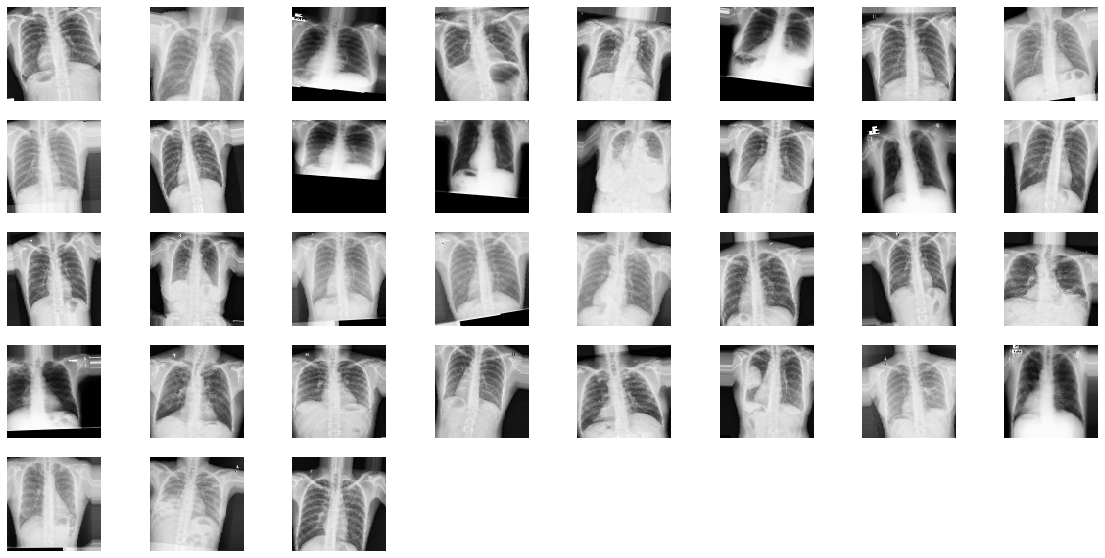

In [ ]:
plots(imgs, titles=None) # titles=labels will display the image labels

**End of Data Preparation==========>>Start of Model Building**

In [ ]:
#Configurer les générateurs
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=train_batch_size,class_mode='categorical')
val_gen = datagen.flow_from_directory(valid_path,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),batch_size=val_batch_size,class_mode='categorical')
# Remarque : shuffle=False empêche le jeu de données de test d'être mélangé
test_gen = datagen.flow_from_directory(valid_path,target_size=(IMAGE_HEIGHT,IMAGE_WIDTH), batch_size=val_batch_size,class_mode='categorical',shuffle=False)

Found 2040 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
#Créer l'architecture du modèle
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.3
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

**Train the Model**

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
filepath = "/content/drive/MyDrive/dataset_4G/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,verbose=1, mode='max', min_lr=0.00001)                              
callbacks_list = [checkpoint, reduce_lr]
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, validation_steps=val_steps,epochs=100, verbose=1,callbacks=callbacks_list)

<ipython-input-58-dc54e7792917>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, validation_steps=val_steps,epochs=100, verbose=1,callbacks=callbacks_list)


Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5074

68/68 [==============================] - 60s 850ms/step - loss: 0.6937 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5162

68/68 [==============================] - 58s 854ms/step - loss: 0.6927 - accuracy: 0.5162 - val_loss: 0.6926 - val_accuracy: 0.4917 - lr: 1.0000e-04
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5132

68/68 [==============================] - 57s 840ms/step - loss: 0.6930 - accuracy: 0.5132 - val_loss: 0.6903 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5882

68/68 [==============================] - 58s 847ms/step - loss: 0.6905 - accuracy: 0.5882 - val_loss: 0.6917 - val_accuracy: 0.4917 - lr: 1.0000e-04
Epoch 5/100
68/68 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5471

68/68 [==============================] - 57s 838ms/step - loss: 0.6833 - accuracy: 0.5471 - val_loss: 0.6631 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 6/100
68/68 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.6132

68/68 [==============================] - 57s 841ms/step - loss: 0.6641 - accuracy: 0.6132 - val_loss: 0.6867 - val_accuracy: 0.6083 - lr: 1.0000e-04
Epoch 7/100
68/68 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6206

68/68 [==============================] - 57s 833ms/step - loss: 0.6558 - accuracy: 0.6206 - val_loss: 0.6225 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 8/100
68/68 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.6426

68/68 [==============================] - 57s 843ms/step - loss: 0.6409 - accuracy: 0.6426 - val_loss: 0.5921 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 9/100
68/68 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.7015

68/68 [==============================] - 57s 840ms/step - loss: 0.5907 - accuracy: 0.7015 - val_loss: 0.5659 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 10/100
68/68 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.7044

68/68 [==============================] - 58s 850ms/step - loss: 0.5895 - accuracy: 0.7044 - val_loss: 0.5409 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 11/100
68/68 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.7191

68/68 [==============================] - 56s 828ms/step - loss: 0.5692 - accuracy: 0.7191 - val_loss: 0.5802 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 12/100
68/68 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7294

68/68 [==============================] - 56s 829ms/step - loss: 0.5559 - accuracy: 0.7294 - val_loss: 0.5456 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 13/100
68/68 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7500

68/68 [==============================] - 56s 827ms/step - loss: 0.5437 - accuracy: 0.7500 - val_loss: 0.5669 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 14/100
68/68 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7353

68/68 [==============================] - 57s 832ms/step - loss: 0.5337 - accuracy: 0.7353 - val_loss: 0.5348 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 15/100
68/68 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.7412

68/68 [==============================] - 56s 817ms/step - loss: 0.5462 - accuracy: 0.7412 - val_loss: 0.5735 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 16/100
68/68 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.7353

68/68 [==============================] - 55s 815ms/step - loss: 0.5366 - accuracy: 0.7353 - val_loss: 0.5243 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 17/100
68/68 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7397

68/68 [==============================] - 56s 821ms/step - loss: 0.5164 - accuracy: 0.7397 - val_loss: 0.5429 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 18/100
68/68 [==============================] - ETA: 0s - loss: 0.5255 - accuracy: 0.7765

68/68 [==============================] - 56s 821ms/step - loss: 0.5255 - accuracy: 0.7765 - val_loss: 0.5460 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 19/100
68/68 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.7676

68/68 [==============================] - 55s 816ms/step - loss: 0.5155 - accuracy: 0.7676 - val_loss: 0.5213 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 20/100
68/68 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.7456

68/68 [==============================] - 55s 815ms/step - loss: 0.5153 - accuracy: 0.7456 - val_loss: 0.5564 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 21/100
68/68 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7779

68/68 [==============================] - 56s 821ms/step - loss: 0.4954 - accuracy: 0.7779 - val_loss: 0.5186 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 22/100
68/68 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7691

68/68 [==============================] - 55s 816ms/step - loss: 0.5064 - accuracy: 0.7691 - val_loss: 0.4992 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 23/100
68/68 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7765

68/68 [==============================] - 56s 817ms/step - loss: 0.4801 - accuracy: 0.7765 - val_loss: 0.5944 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 24/100
68/68 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7721

68/68 [==============================] - 56s 818ms/step - loss: 0.5059 - accuracy: 0.7721 - val_loss: 0.5334 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 25/100
68/68 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8015

68/68 [==============================] - 57s 841ms/step - loss: 0.4720 - accuracy: 0.8015 - val_loss: 0.5540 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 26/100
68/68 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7824

68/68 [==============================] - 57s 845ms/step - loss: 0.4958 - accuracy: 0.7824 - val_loss: 0.5409 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 27/100
68/68 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7838

68/68 [==============================] - 60s 885ms/step - loss: 0.5022 - accuracy: 0.7838 - val_loss: 0.6161 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 28/100
68/68 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.7779

68/68 [==============================] - 58s 847ms/step - loss: 0.4879 - accuracy: 0.7779 - val_loss: 0.5639 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 29/100
68/68 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.7809

68/68 [==============================] - 58s 849ms/step - loss: 0.4831 - accuracy: 0.7809 - val_loss: 0.5387 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 30/100
68/68 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.7721

68/68 [==============================] - 57s 838ms/step - loss: 0.4852 - accuracy: 0.7721 - val_loss: 0.5346 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 31/100
68/68 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.7824

68/68 [==============================] - 57s 844ms/step - loss: 0.4875 - accuracy: 0.7824 - val_loss: 0.5643 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 32/100
68/68 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7838

68/68 [==============================] - 57s 837ms/step - loss: 0.4738 - accuracy: 0.7838 - val_loss: 0.5214 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 33/100
68/68 [==============================] - ETA: 0s - loss: 0.4573 - accuracy: 0.7985

68/68 [==============================] - 58s 857ms/step - loss: 0.4573 - accuracy: 0.7985 - val_loss: 0.5593 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 34/100
68/68 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.7794

68/68 [==============================] - 58s 852ms/step - loss: 0.4896 - accuracy: 0.7794 - val_loss: 0.5263 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 35/100
68/68 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.7882

68/68 [==============================] - 58s 855ms/step - loss: 0.4668 - accuracy: 0.7882 - val_loss: 0.5366 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 36/100
68/68 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.7779

68/68 [==============================] - 57s 835ms/step - loss: 0.4597 - accuracy: 0.7779 - val_loss: 0.5254 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 37/100
68/68 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8044

68/68 [==============================] - 57s 835ms/step - loss: 0.4556 - accuracy: 0.8044 - val_loss: 0.5158 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 38/100
68/68 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7838

68/68 [==============================] - 57s 837ms/step - loss: 0.4638 - accuracy: 0.7838 - val_loss: 0.5213 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 39/100
68/68 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.7853

68/68 [==============================] - 57s 838ms/step - loss: 0.4720 - accuracy: 0.7853 - val_loss: 0.5132 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 40/100
68/68 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.7765

68/68 [==============================] - 57s 833ms/step - loss: 0.4632 - accuracy: 0.7765 - val_loss: 0.5075 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 41/100
68/68 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.7838

68/68 [==============================] - 57s 838ms/step - loss: 0.4656 - accuracy: 0.7838 - val_loss: 0.5006 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 42/100
68/68 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8176

68/68 [==============================] - 58s 848ms/step - loss: 0.4483 - accuracy: 0.8176 - val_loss: 0.5203 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 43/100
68/68 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.7838

68/68 [==============================] - 57s 841ms/step - loss: 0.4622 - accuracy: 0.7838 - val_loss: 0.5289 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 44/100
68/68 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8059

68/68 [==============================] - 58s 848ms/step - loss: 0.4480 - accuracy: 0.8059 - val_loss: 0.5216 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 45/100
68/68 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7882

68/68 [==============================] - 57s 832ms/step - loss: 0.4635 - accuracy: 0.7882 - val_loss: 0.5273 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 46/100
68/68 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8103

68/68 [==============================] - 57s 842ms/step - loss: 0.4329 - accuracy: 0.8103 - val_loss: 0.5316 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 47/100
68/68 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.7971

68/68 [==============================] - 57s 839ms/step - loss: 0.4520 - accuracy: 0.7971 - val_loss: 0.5492 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 48/100
68/68 [==============================] - ETA: 0s - loss: 0.4612 - accuracy: 0.7971

68/68 [==============================] - 57s 831ms/step - loss: 0.4612 - accuracy: 0.7971 - val_loss: 0.5288 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 49/100
68/68 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8088

68/68 [==============================] - 57s 832ms/step - loss: 0.4425 - accuracy: 0.8088 - val_loss: 0.5162 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 50/100
68/68 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.7912

68/68 [==============================] - 57s 841ms/step - loss: 0.4530 - accuracy: 0.7912 - val_loss: 0.5050 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 51/100
68/68 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8132

68/68 [==============================] - 57s 838ms/step - loss: 0.4304 - accuracy: 0.8132 - val_loss: 0.5535 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 52/100
68/68 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.7868

68/68 [==============================] - 57s 840ms/step - loss: 0.4628 - accuracy: 0.7868 - val_loss: 0.4896 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 53/100
68/68 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8000

68/68 [==============================] - 57s 845ms/step - loss: 0.4221 - accuracy: 0.8000 - val_loss: 0.5511 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 54/100
68/68 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.7794

68/68 [==============================] - 58s 851ms/step - loss: 0.4840 - accuracy: 0.7794 - val_loss: 0.5240 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 55/100
68/68 [==============================] - ETA: 0s - loss: 0.4550 - accuracy: 0.8059

68/68 [==============================] - 58s 846ms/step - loss: 0.4550 - accuracy: 0.8059 - val_loss: 0.5440 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 56/100
68/68 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.7971

68/68 [==============================] - 57s 832ms/step - loss: 0.4599 - accuracy: 0.7971 - val_loss: 0.5146 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 57/100
68/68 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.7853

68/68 [==============================] - 57s 837ms/step - loss: 0.4514 - accuracy: 0.7853 - val_loss: 0.5026 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 58/100
68/68 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.7971

68/68 [==============================] - 58s 846ms/step - loss: 0.4644 - accuracy: 0.7971 - val_loss: 0.5184 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 59/100
68/68 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8206

68/68 [==============================] - 57s 831ms/step - loss: 0.4147 - accuracy: 0.8206 - val_loss: 0.5471 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 60/100
68/68 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7956

68/68 [==============================] - 57s 845ms/step - loss: 0.4337 - accuracy: 0.7956 - val_loss: 0.5090 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 61/100
68/68 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8118

68/68 [==============================] - 57s 837ms/step - loss: 0.4365 - accuracy: 0.8118 - val_loss: 0.5210 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 62/100
68/68 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8059

68/68 [==============================] - 57s 839ms/step - loss: 0.4229 - accuracy: 0.8059 - val_loss: 0.4960 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 63/100
68/68 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8206

68/68 [==============================] - 57s 838ms/step - loss: 0.4249 - accuracy: 0.8206 - val_loss: 0.5265 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 64/100
68/68 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.8132

68/68 [==============================] - 57s 833ms/step - loss: 0.4100 - accuracy: 0.8132 - val_loss: 0.5413 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 65/100
68/68 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.7985

68/68 [==============================] - 57s 837ms/step - loss: 0.4305 - accuracy: 0.7985 - val_loss: 0.5204 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 66/100
68/68 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8426

68/68 [==============================] - 57s 839ms/step - loss: 0.3766 - accuracy: 0.8426 - val_loss: 0.5121 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 67/100
68/68 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7882

68/68 [==============================] - 56s 831ms/step - loss: 0.4581 - accuracy: 0.7882 - val_loss: 0.5422 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 68/100
68/68 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8103

68/68 [==============================] - 57s 836ms/step - loss: 0.4070 - accuracy: 0.8103 - val_loss: 0.5170 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 69/100
68/68 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8397

68/68 [==============================] - 56s 820ms/step - loss: 0.3976 - accuracy: 0.8397 - val_loss: 0.5175 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 70/100
68/68 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.8059

68/68 [==============================] - 56s 827ms/step - loss: 0.4284 - accuracy: 0.8059 - val_loss: 0.5333 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 71/100
68/68 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8015

68/68 [==============================] - 57s 834ms/step - loss: 0.4404 - accuracy: 0.8015 - val_loss: 0.5200 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 72/100
68/68 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8044

68/68 [==============================] - 57s 839ms/step - loss: 0.4391 - accuracy: 0.8044 - val_loss: 0.5366 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 73/100
68/68 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8294

68/68 [==============================] - 57s 842ms/step - loss: 0.3968 - accuracy: 0.8294 - val_loss: 0.5181 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 74/100
68/68 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8103

68/68 [==============================] - 57s 839ms/step - loss: 0.4071 - accuracy: 0.8103 - val_loss: 0.5137 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 75/100
68/68 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8221

68/68 [==============================] - 57s 844ms/step - loss: 0.3892 - accuracy: 0.8221 - val_loss: 0.5131 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 76/100
68/68 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8368

68/68 [==============================] - 57s 837ms/step - loss: 0.3966 - accuracy: 0.8368 - val_loss: 0.5275 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 77/100
68/68 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8132

68/68 [==============================] - 57s 841ms/step - loss: 0.3991 - accuracy: 0.8132 - val_loss: 0.5127 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 78/100
68/68 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8309

68/68 [==============================] - 57s 844ms/step - loss: 0.3888 - accuracy: 0.8309 - val_loss: 0.5117 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 79/100
68/68 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8250

68/68 [==============================] - 57s 835ms/step - loss: 0.3956 - accuracy: 0.8250 - val_loss: 0.4901 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 80/100
68/68 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8206

68/68 [==============================] - 56s 830ms/step - loss: 0.3970 - accuracy: 0.8206 - val_loss: 0.5245 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 81/100
68/68 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8103

68/68 [==============================] - 58s 847ms/step - loss: 0.4042 - accuracy: 0.8103 - val_loss: 0.4880 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 82/100
68/68 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8309

68/68 [==============================] - 56s 826ms/step - loss: 0.3920 - accuracy: 0.8309 - val_loss: 0.5333 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 83/100
68/68 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8191

68/68 [==============================] - 57s 831ms/step - loss: 0.4108 - accuracy: 0.8191 - val_loss: 0.5339 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 84/100
68/68 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8059

68/68 [==============================] - 57s 834ms/step - loss: 0.4049 - accuracy: 0.8059 - val_loss: 0.5031 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 85/100
68/68 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8338

68/68 [==============================] - 57s 843ms/step - loss: 0.3860 - accuracy: 0.8338 - val_loss: 0.5068 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 86/100
68/68 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8309

68/68 [==============================] - 57s 836ms/step - loss: 0.3768 - accuracy: 0.8309 - val_loss: 0.4968 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 87/100
68/68 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8368

68/68 [==============================] - 56s 830ms/step - loss: 0.3856 - accuracy: 0.8368 - val_loss: 0.4856 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 88/100
68/68 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8162

68/68 [==============================] - 58s 847ms/step - loss: 0.4104 - accuracy: 0.8162 - val_loss: 0.5131 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 89/100
68/68 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8382

68/68 [==============================] - 57s 833ms/step - loss: 0.3954 - accuracy: 0.8382 - val_loss: 0.4982 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 90/100
68/68 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8118

68/68 [==============================] - 56s 830ms/step - loss: 0.4062 - accuracy: 0.8118 - val_loss: 0.5087 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 91/100
68/68 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8324

68/68 [==============================] - 57s 837ms/step - loss: 0.3812 - accuracy: 0.8324 - val_loss: 0.5308 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 92/100
68/68 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.7868

68/68 [==============================] - 57s 835ms/step - loss: 0.4382 - accuracy: 0.7868 - val_loss: 0.5303 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 93/100
68/68 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8368

68/68 [==============================] - 57s 841ms/step - loss: 0.4019 - accuracy: 0.8368 - val_loss: 0.4838 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 94/100
68/68 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8221

68/68 [==============================] - 56s 825ms/step - loss: 0.3870 - accuracy: 0.8221 - val_loss: 0.5274 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 95/100
68/68 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8176

68/68 [==============================] - 57s 839ms/step - loss: 0.3929 - accuracy: 0.8176 - val_loss: 0.4977 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 96/100
68/68 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8426

68/68 [==============================] - 58s 846ms/step - loss: 0.3473 - accuracy: 0.8426 - val_loss: 0.4732 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 97/100
68/68 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.8382

68/68 [==============================] - 57s 844ms/step - loss: 0.3733 - accuracy: 0.8382 - val_loss: 0.5042 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 98/100
68/68 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8250

68/68 [==============================] - 57s 839ms/step - loss: 0.3967 - accuracy: 0.8250 - val_loss: 0.5123 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 99/100
68/68 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8294

68/68 [==============================] - 57s 839ms/step - loss: 0.3779 - accuracy: 0.8294 - val_loss: 0.4985 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 100/100
68/68 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8338

68/68 [==============================] - 58s 850ms/step - loss: 0.3604 - accuracy: 0.8338 - val_loss: 0.5534 - val_accuracy: 0.7417 - lr: 1.0000e-04


In [ ]:
#Évaluer le modèle à l'aide de l'ensemble de valeurs
#obtenir les noms des métriques afin que nous puissions utiliser evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
#Ici, la meilleure époque sera utilisée.
model.load_weights('/content/drive/MyDrive/dataset_4G/model.h5')
val_loss, val_acc = model.evaluate_generator(test_gen,steps=val_steps)
print('val_loss:', val_loss)
print('val_acc:', val_acc)


<ipython-input-60-318b7ec65978>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_acc = model.evaluate_generator(test_gen,steps=val_steps)


val_loss: 0.5374653339385986
val_acc: 0.7833333611488342


In [ ]:
#Tracer les courbes d'entraînement
# Get the labels of the test images.
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
#Créer une matrice de confusion
# Obtenez les étiquettes des images de test.
test_labels = test_gen.classes

In [ ]:
# Nous en avons besoin pour tracer la matrice de confusion.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# Imprimer l'étiquette associée à chaque classe
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [ ]:
# faire une prédiction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

<ipython-input-65-82d2c123f4cd>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)


12/12 [==============================] - 3s 207ms/step


In [ ]:
predictions.shape

(120, 2)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    #Cette fonction imprime et trace la matrice de confusion.
    #La normalisation peut être appliquée en définissant `normalize=True`.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion, sans normalisation')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(120,)

In [ ]:
# argmax renvoie l'index de la valeur maximale d'une ligne
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [ ]:
# Définir les étiquettes des indices de classe. Ceux-ci doivent correspondre à la
# commande indiquée ci-dessus.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
#Créer un rapport de classement
# Obtenir les noms de fichiers, les étiquettes et les prédictions associées
# Ceci affiche la séquence dans laquelle le générateur a traité les images de test
test_filenames = test_gen.filenames
# Obtenez les vraies étiquettes
y_true = test_gen.classes
# Obtenir les étiquettes prédites
y_pred = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report
# Générer un rapport de classement , matrice de confusion
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.74      0.89      0.81        61
Tuberculosis       0.85      0.68      0.75        59

    accuracy                           0.78       120
   macro avg       0.80      0.78      0.78       120
weighted avg       0.79      0.78      0.78       120

